In [301]:
import re
import multiprocessing
from tqdm import tqdm

import pandas as pd
from wordcloud import WordCloud, STOPWORDS
from scipy.stats import norm
from gensim.models import word2vec
from kaggle.competitions import twosigmanews

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook

from nltk.tokenize import TweetTokenizer # a tweet tokenizer from nltk.
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

%matplotlib inline

In [302]:
cpu_count = 2*multiprocessing.cpu_count()-1
print('Number of CPUs: {}'.format(cpu_count))

Number of CPUs: 7


In [ ]:
env = twosigmanews.make_env()
print('Done!')

In [303]:
(market_train_df, news_train_df) = env.get_training_data()

In [304]:
assetName = 'Companhia de Bebidas das Americas Ambev'

In [305]:
df = market_train_df[market_train_df['assetName']==assetName]
df_news = news_train_df[news_train_df['assetName'] == assetName]

In [306]:
df.head()

,time,assetCode,assetName,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,universe
9,2007-02-01 22:00:00+00:00,ABV.N,Companhia de Bebidas das Americas Ambev,401800.0,52.46,52.10,0.014112,0.024784,NaN,NaN,0.042321,0.027411,NaN,NaN,0.012917,1.0
1427,2007-02-02 22:00:00+00:00,ABV.N,Companhia de Bebidas das Americas Ambev,466900.0,52.24,52.44,-0.004194,0.006526,-0.007681,-0.004428,0.043131,0.037594,NaN,NaN,-0.003625,1.0
2850,2007-02-05 22:00:00+00:00,ABV.N,Companhia de Bebidas das Americas Ambev,412100.0,52.89,52.45,0.012443,0.000191,0.014379,-0.003055,0.037669,0.036561,NaN,NaN,-0.022135,1.0
4278,2007-02-06 22:00:00+00:00,ABV.N,Companhia de Bebidas das Americas Ambev,258800.0,52.90,52.88,0.000189,0.008198,-0.001021,0.009998,0.030185,0.038900,NaN,NaN,-0.019556,1.0
5709,2007-02-07 22:00:00+00:00,ABV.N,Companhia de Bebidas das Americas Ambev,252000.0,52.52,52.89,-0.007183,0.000189,-0.009568,-0.000337,0.010778,0.026392,NaN,NaN,0.021846,1.0


In [307]:
data_from = '2012-03-10'
data_to = '2014-09-10'

df_small = df[ (df['time']>data_from) & (df['time'] < data_to)]
df_news_small = df_news[(df_news['time'] > data_from) & (df_news['time'] < data_to)]

"\nplt.subplot(2,1,2)\nplt.plot(df_news_small['time'], df_news_small['sentimentNegative'], '--ro', label='Neg')\nplt.plot(df_news_small['time'], df_news_small['sentimentNeutral'], '--bo', label='Neu')\nplt.plot(df_news_small['time'], df_news_small['sentimentPositive'], '--go', label='Pos')\nplt.legend()\n"

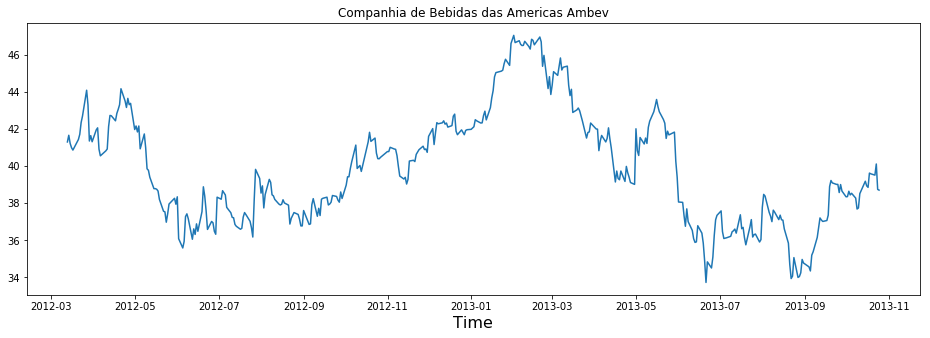

In [325]:
plt.figure(figsize=(16,5))

#plt.subplot(2,1,1)
plt.plot(df_small['time'], df_small['close'])
plt.title(assetName)
plt.xlabel('Time', fontsize=16)
'''
plt.subplot(2,1,2)
plt.plot(df_news_small['time'], df_news_small['sentimentNegative'], '--ro', label='Neg')
plt.plot(df_news_small['time'], df_news_small['sentimentNeutral'], '--bo', label='Neu')
plt.plot(df_news_small['time'], df_news_small['sentimentPositive'], '--go', label='Pos')
plt.legend()
'''

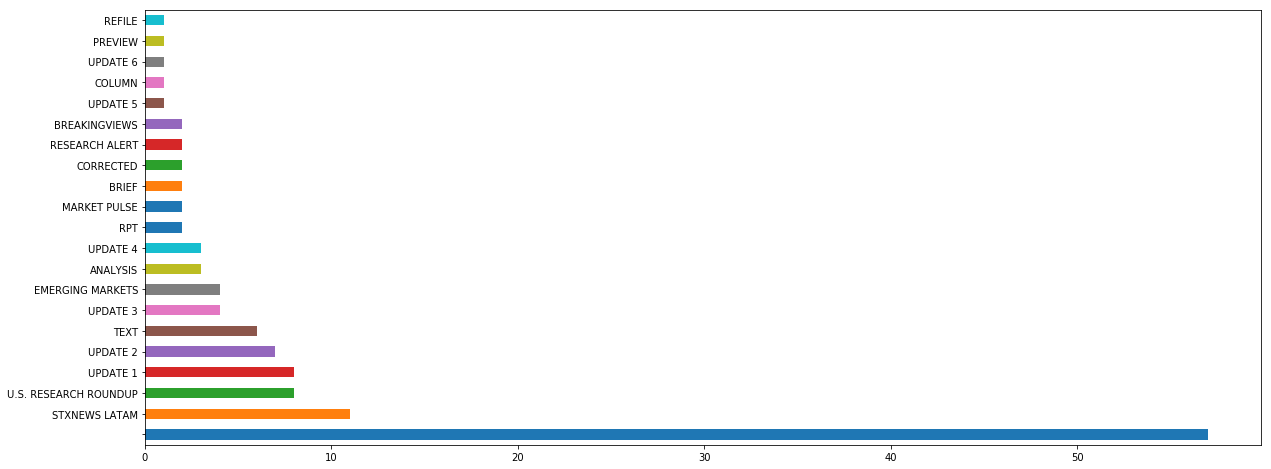

In [309]:
plt.figure(figsize=(20,8))
pd.value_counts(df_news_small['headlineTag']).plot(kind="barh")

In [310]:
df_news_small['headline'].head()

4521683    JP MORGAN RAISES GRUPO MODELO <GMODELOC.MX> PR...
4521684    JP MORGAN RAISES CCU <CCU.N> PRICE TARGET TO $...
4521687    BRIEF-RESEARCH ALERT-JP Morgan raises Ambev, o...
4529005    STXNEWS LATAM-Buy Vale, Itaú; sell Usiminas, H...
4539144      MOODY'S COMMENTS ON ABI ACQUISITION SPECULATION
Name: headline, dtype: object

In [311]:
def get_wordCloud(corpus):
    wordCloud = WordCloud(background_color='white',
                              stopwords=STOPWORDS,
                              width=3000,
                              height=2500,
                              max_words=200,
                              random_state=42
                         ).generate(str(corpus))
    return wordCloud

In [312]:
def get_corpus(data):
    corpus = []
    for phrase in data:
        for word in phrase.split():
            corpus.append(word)
    return corpus

In [313]:
corpus = get_corpus(df_news_small['headline'].values)
procWordCloud = get_wordCloud(corpus)

In [314]:
df_news_small['headline'].head()

4521683    JP MORGAN RAISES GRUPO MODELO <GMODELOC.MX> PR...
4521684    JP MORGAN RAISES CCU <CCU.N> PRICE TARGET TO $...
4521687    BRIEF-RESEARCH ALERT-JP Morgan raises Ambev, o...
4529005    STXNEWS LATAM-Buy Vale, Itaú; sell Usiminas, H...
4539144      MOODY'S COMMENTS ON ABI ACQUISITION SPECULATION
Name: headline, dtype: object

Text(0.5,0,'Number of words in headline news')

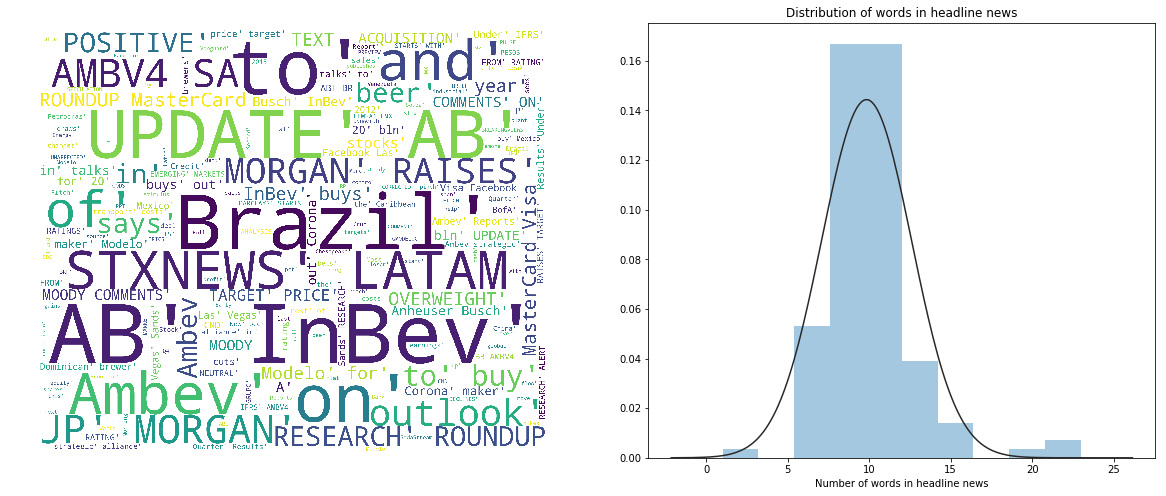

In [315]:
fig = plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
plt.imshow(procWordCloud)
plt.axis('off')

plt.subplot(1,2,2)

words_count = [len(x.split(' ')) for x in df_news_small['headline'].values]
sns.distplot(words_count,hist=True, kde=False, bins=10, fit=norm)
plt.title("Distribution of words in headline news")
plt.xlabel('Number of words in headline news')

**Text Features Extraction**

In [316]:
class TextDataset():

    def __init__(self, df, lang = 'english'):

        self.data = df

        self.tokenizer = TweetTokenizer()
        self.stop_words = set(stopwords.words(lang))
        self.lemmatizer = WordNetLemmatizer()
        self.ps = PorterStemmer()
        
    def _get_tokens(self, words):    
        return [word.lower() for word in words.split()]
    
    def _removeStopwords(self, words):
        # Removing all the stopwords
        return [word for word in words if word not in self.stop_words]

    def _removePonctuation(self, words):
        return re.sub(r'[^\w\s]', '', words)

    def _lemmatizing(self, words):
        #Lemmatizing
        return [self.lemmatizer.lemmatize(word) for word in words]

    def _stemming(self, words):
        #Stemming
        return [self.ps.stem(word) for word in words]


    def process_data(self, col = 'content', remove_pontuation = True,  remove_stopw = False, remove_tags = False, lemmalize = False, stem = False):

        self.data = self.data.drop_duplicates(subset=col, keep="last")
        
        proc_col = col
        if remove_pontuation:
            proc_col = col + '_data'
            self.data[proc_col] = self.data[col].apply(lambda x: self._removePonctuation(x) )
        
        # get tokens of the sentence
        self.data[proc_col] = self.data[proc_col].apply(lambda x: self._get_tokens(x))
        if remove_stopw:
            self.data[proc_col] = self.data[proc_col].apply(lambda x: self._removeStopwords(x)) 
        if lemmalize:
            self.data[proc_col] = self.data[proc_col].apply(lambda x: self._lemmatizing(x) )
        if stem:
            self.data[proc_col] = self.data[proc_col].apply(lambda x: self._stemming(x))

        self.data['nb_words'] = self.data[proc_col].apply(lambda x: len(x))
        self.proc_col = proc_col
        
    def __len__(self):
        return len(self.data)

In [317]:
textDataset = TextDataset(df_news_small)

In [326]:
textDataset.process_data(col='headline')

In [319]:
textDataset.data['headline_data'].head()

4521683    [jp, morgan, raises, grupo, modelo, gmodelocmx...
4521684    [jp, morgan, raises, ccu, ccun, price, target,...
4521687    [briefresearch, alertjp, morgan, raises, ambev...
4529005    [stxnews, latambuy, vale, itaú, sell, usiminas...
4539144    [moodys, comments, on, abi, acquisition, specu...
Name: headline_data, dtype: object

In [320]:
X = textDataset.data['headline_data'].values

In [321]:
# Set values for various parameters
num_features = 3    # Word vector dimensionality                      
min_word_count = 2   # Minimum word count                        
num_workers = cpu_count  # Number of threads to run in parallel
context = 3          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words


W2Vmodel = word2vec.Word2Vec(workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)


W2Vmodel.build_vocab(X)

W2Vmodel.train(X, \
            total_examples=W2Vmodel.corpus_count, epochs=W2Vmodel.epochs)

(2319, 5695)

In [322]:
def plot_tSNE(model,n_samples = 5000):

    #https://www.oreilly.com/learning/an-illustrated-introduction-to-the-t-sne-algorithm
    output_notebook()
    fig = bp.figure(plot_width=700, plot_height=600, title="A map of " + str(n_samples) + " word vectors",
        tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
        x_axis_type=None, y_axis_type=None, min_border=1)


    word_vectors = [model[w] for w in model.wv.vocab.keys()][:n_samples]
    #word_vectors = [token for token in f_matrix_train][0:n_samples]

    tsne_model = TSNE(n_components=2, verbose=1, random_state=23)
    tsne_w2v = tsne_model.fit_transform(word_vectors)

    tsne_df = pd.DataFrame(tsne_w2v, columns=['x', 'y'])
    tsne_df['words'] = [k for k in model.wv.vocab.keys()][:n_samples]

    fig.scatter(x='x', y='y', source=tsne_df)
    hover = fig.select(dict(type=HoverTool))
    hover.tooltips={"word": "@words"}
    show(fig)

In [323]:
plot_tSNE(W2Vmodel)

Loading BokehJS ...

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 177 samples in 0.000s...
[t-SNE] Computed neighbors for 177 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 177 / 177
[t-SNE] Mean sigma: 0.077166
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.412273
[t-SNE] KL divergence after 1000 iterations: 0.439153
